# Results on ENCODE ChIP-seq data using JASPAR2014 binding profiles for ChIP'ed TFs

1st and 2nd order DNA shape features were used with DiMO-optimized PSSMs. The background sequences were obtained by dinuc shuffling of the foreground sequences.

## Data sets

In [1]:
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
from matplotlib.pyplot import savefig
import pandas as pd
import numpy as np
data = pd.read_csv("data/20150317/wgEncodeAwgTfbs_with_JASPAR_MA.csv",
                   header=0, index_col=0, names=["ENCODE_data_set", "TF_name", "JASPAR_id"])

In [2]:
def auc_val(inline):
    return eval(inline.split(' ')[-1])

import os
rep = '20151120_JasparDinucMatchedChipseqScaledDnashape2ndOrderDimo/'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUROC'] = auc_val(first_line)
                second_line = stream.readline()
                assert second_line.startswith('PR AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUPRC'] = auc_val(second_line)
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC TFFM')
                data.loc[repo, 'TFFM_AUROC'] = auc_val(third_line)
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC TFFM')
                data.loc[repo, 'TFFM_AUPRC'] = auc_val(fourth_line)
                fifth_line = stream.readline()
                assert fifth_line.startswith('ROC AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUROC'] = auc_val(fifth_line)
                sixth_line = stream.readline()
                assert sixth_line.startswith('PR AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUPRC'] = auc_val(sixth_line)
                seventh_line = stream.readline()
                assert seventh_line.startswith('ROC AUC PWM')
                data.loc[repo, 'PSSM_AUROC'] = auc_val(seventh_line)
                eighth_line = stream.readline()
                assert eighth_line.startswith('PR AUC PWM')
                data.loc[repo, 'PSSM_AUPRC'] = auc_val(eighth_line)
                data.loc[repo, 'TFFM_AUROC_improvement'] = data.loc[repo, 'TFFM_dnashape_AUROC'] - data.loc[repo, 'TFFM_AUROC']
                data.loc[repo, 'TFFM_AUPRC_improvement'] = data.loc[repo, 'TFFM_dnashape_AUPRC'] - data.loc[repo, 'TFFM_AUPRC']
                data.loc[repo, 'PSSM_AUROC_improvement'] = data.loc[repo, 'PSSM_dnashape_AUROC'] - data.loc[repo, 'PSSM_AUROC']
                data.loc[repo, 'PSSM_AUPRC_improvement'] = data.loc[repo, 'PSSM_dnashape_AUPRC'] - data.loc[repo, 'PSSM_AUPRC']

## TFFM analyses


### Results on all the ChIP-seq experiments

In [3]:
print "TFFM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUROC"] > data["TFFM_AUROC"]]), len(data.dropna()))
print "TFFM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUPRC"] > data["TFFM_AUPRC"]]), len(data.dropna()))

TFFM-based classifiers have higher AUROC in 397 over 400 cases
TFFM-based classifiers have higher AUPRC in 397 over 400 cases


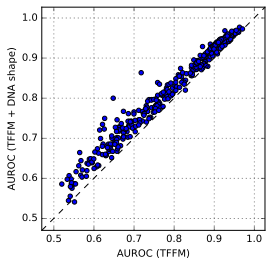

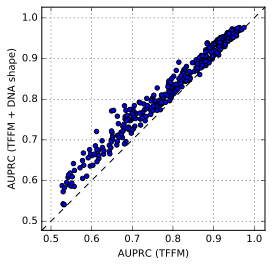

In [4]:
mini = min(min(data.dropna()["TFFM_AUROC"]), min(data.dropna()["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUROC"]), max(data.dropna()["TFFM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUROC", y="TFFM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_TFFM_TFFM+DNAshape.svg")

mini = min(min(data.dropna()["TFFM_AUPRC"]), min(data.dropna()["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUPRC"]), max(data.dropna()["TFFM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUPRC", y="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_TFFM_TFFM+DNAshape.svg")

In the following figure, we plot the ratio of AUCs obtained with the TFFM scores and the classifier.

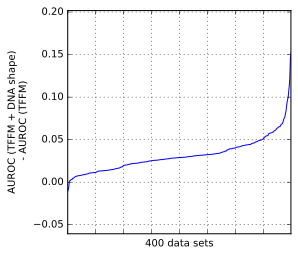

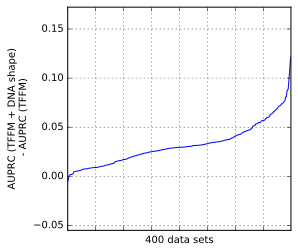

In [5]:
data = data.sort("TFFM_AUROC_improvement")
axes = data.dropna().plot(y="TFFM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (TFFM + DNA shape)\n - AUROC (TFFM)")
axes.set_ylim(min(data.TFFM_AUROC_improvement) - 0.05,
              max(data.TFFM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_TFFM_TFFM+DNAshape.svg")

data = data.sort("TFFM_AUPRC_improvement")
axes = data.dropna().plot(y="TFFM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (TFFM + DNA shape)\n - AUPRC (TFFM)")
axes.set_ylim(min(data.TFFM_AUPRC_improvement) - 0.05,
              max(data.TFFM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_TFFM_TFFM+DNAshape.svg")

## PSSM analyses

### Results on all the ChIP-seq experiments

In [6]:
print "PSSM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUROC"] > data["PSSM_AUROC"]]), len(data.dropna()))
print "PSSM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUPRC"] > data["PSSM_AUPRC"]]), len(data.dropna()))

PSSM-based classifiers have higher AUROC in 400 over 400 cases
PSSM-based classifiers have higher AUPRC in 399 over 400 cases


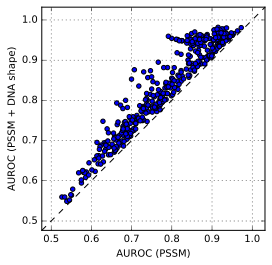

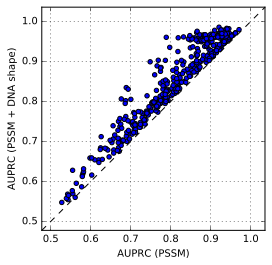

In [7]:
mini = min(min(data.dropna()["PSSM_AUROC"]), min(data.dropna()["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["PSSM_AUROC"]), max(data["PSSM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUROC", y="PSSM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_PSSM_PSSM+DNAshape.svg")

mini = min(min(data["PSSM_AUPRC"]), min(data["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["PSSM_AUPRC"]), max(data["PSSM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUPRC", y="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_PSSM_PSSM+DNAshape.svg")

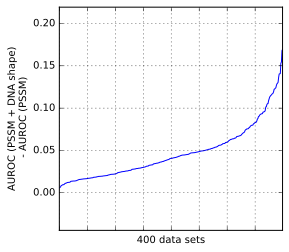

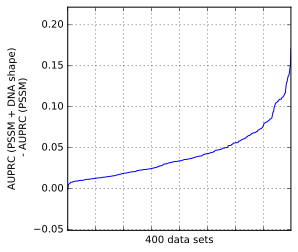

In [8]:
data = data.sort("PSSM_AUROC_improvement")
axes = data.dropna().plot(y="PSSM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (PSSM + DNA shape)\n - AUROC (PSSM)")
axes.set_ylim(min(data.PSSM_AUROC_improvement) - 0.05,
              max(data.PSSM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_PSSM_PSSM+DNAshape.svg")

data = data.sort("PSSM_AUPRC_improvement")
axes = data.dropna().plot(y="PSSM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (PSSM + DNA shape)\n - AUPRC (PSSM)")
axes.set_ylim(min(data.PSSM_AUPRC_improvement) - 0.05,
              max(data.PSSM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_PSSM_PSSM+DNAshape.svg")